This will be our project proposal

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
tennis <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")
#tennis 

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Used Variables:

First Column (which we will rename ID_Num),
Height,
Age,
Hand,
Rank,
Ace,
Double Faults (df),
Surface

75% Training 25% Testing

In [16]:
tennis_named <- tennis|>
    rename("ID_num" = 1 )
tennis_smaller <- tennis_named|>
    select(ID_num,winner_hand,winner_ht,winner_age, winner_rank,surface, loser_hand,loser_ht, loser_age, loser_rank)|>
    mutate(ID_num = as_factor(ID_num), winner_hand = as_factor(winner_hand))
tennis_pivot <- tennis_smaller |>
    pivot_longer(cols = c("winner_rank", "loser_rank"),
                     names_to = "wol_rank",
                     values_to = "rank") |>
    pivot_longer(cols = c("winner_ht", "loser_ht"),
                     names_to = "wol_height",
                     values_to = "height") |>
    pivot_longer(cols = c("winner_age", "loser_age"),
                     names_to = "wol_age",
                     values_to = "age") |>
    pivot_longer(cols = c("winner_hand", "loser_hand"),
                     names_to = "wol_hand",
                     values_to = "hand")
tennis_pivot |>
            slice(1 : 10)
#
#Filter all the NA first before continuing

ID_num,surface,wol_rank,rank,wol_height,height,wol_age,age,wol_hand,hand
<fct>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
0,Hard,winner_rank,9,winner_ht,178,winner_age,29.00479,winner_hand,R
0,Hard,winner_rank,9,winner_ht,178,winner_age,29.00479,loser_hand,R
0,Hard,winner_rank,9,winner_ht,178,loser_age,22.88569,winner_hand,R
0,Hard,winner_rank,9,winner_ht,178,loser_age,22.88569,loser_hand,R
0,Hard,winner_rank,9,loser_ht,NA,winner_age,29.00479,winner_hand,R
0,Hard,winner_rank,9,loser_ht,NA,winner_age,29.00479,loser_hand,R
0,Hard,winner_rank,9,loser_ht,NA,loser_age,22.88569,winner_hand,R
0,Hard,winner_rank,9,loser_ht,NA,loser_age,22.88569,loser_hand,R
0,Hard,loser_rank,16,winner_ht,178,winner_age,29.00479,winner_hand,R


In [8]:
tennis_mean <- tennis_pivot|>
    group_by(rank, surface, hand) |>
    summarize(mean_ht = mean(height, na.rm = TRUE), mean_age = mean(age))
head(tennis_mean, 10)

`summarise()` has grouped output by 'rank', 'surface'. You can override using
the `.groups` argument.


rank,surface,hand,mean_ht,mean_age
<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,Clay,L,185.3214,29.61405
1,Clay,R,186.9524,29.13028
1,Grass,L,185.5833,29.47793
1,Grass,R,186.3857,30.47293
1,Hard,L,186.3253,29.04523
1,Hard,R,187.4488,29.58200
1,Hard,U,185.0000,27.59069
2,Clay,L,184.8364,30.37757
2,Clay,R,185.2842,29.35792


In [10]:
tennis_split <- initial_split(tennis_mean, prop = 0.75, strata = rank )
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

In [11]:
tennis_training

rank,surface,hand,mean_ht,mean_age
<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,Clay,L,185.3214,29.61405
1,Grass,R,186.3857,30.47293
1,Hard,L,186.3253,29.04523
1,Hard,U,185.0000,27.59069
2,Clay,R,185.2842,29.35792
2,Clay,U,185.0000,30.76797
2,Grass,L,185.3600,31.39799
2,Grass,R,186.7907,32.17278
2,Hard,R,186.2174,30.85268


Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 156 rows containing missing values (geom_point).”


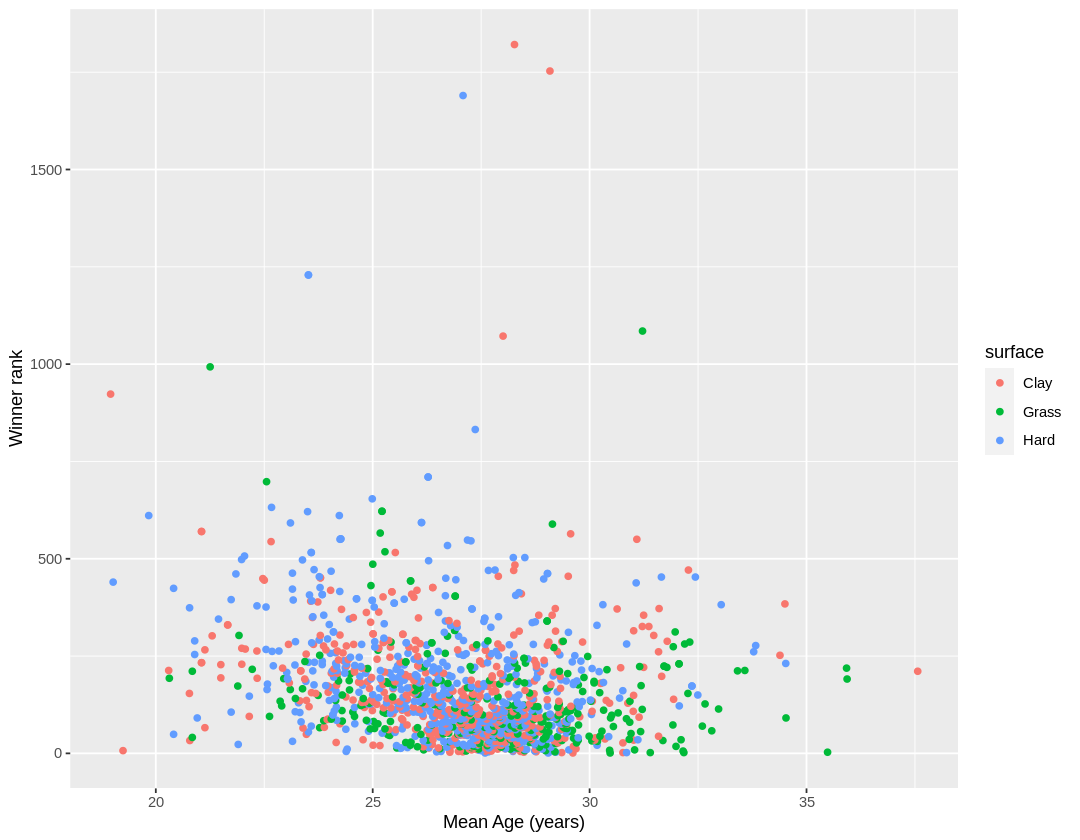

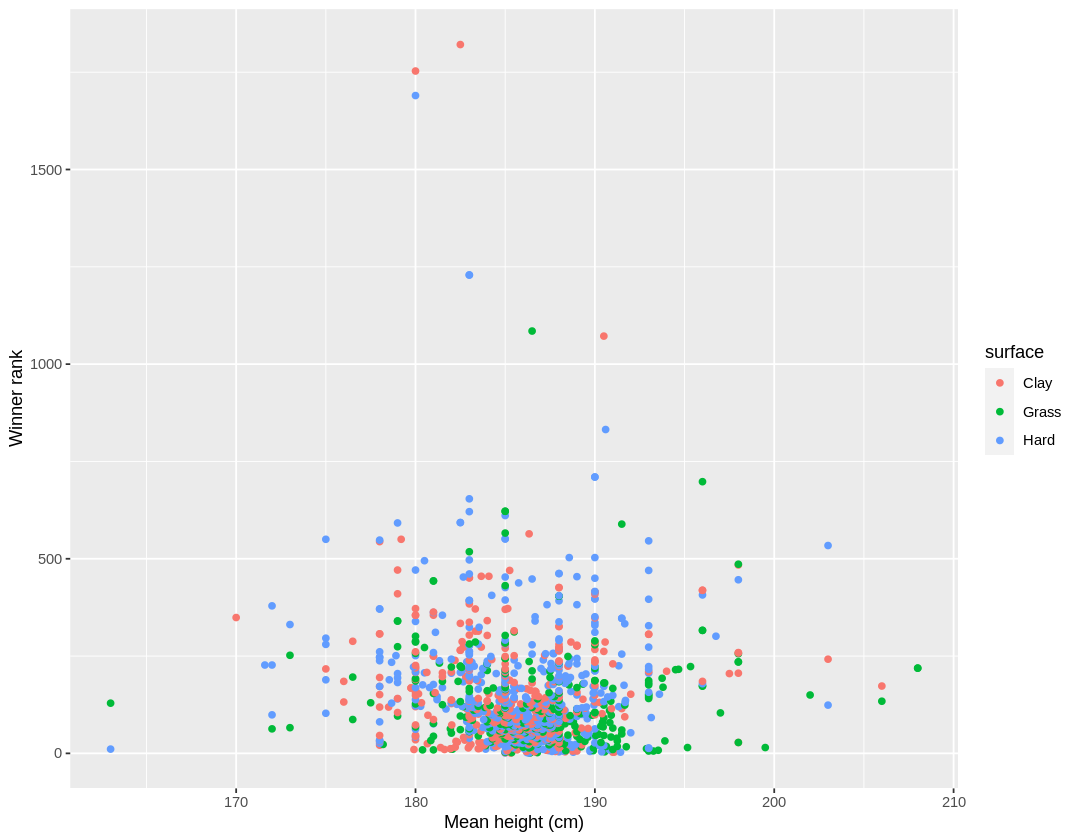

In [15]:
options(repr.plot.width = 9, repr.plot.height = 7)
rank_vs_age_plot <- tennis_training|>
    filter(surface == "Clay"| surface == "Grass"| surface == "Hard")|>
    ggplot(aes(x=mean_age, y=rank, colour = surface))+
    geom_point() +
    labs(x = "Mean Age (years)", y = "Winner rank")
rank_vs_age_plot
#
# use facet_grid
#
rank_vs_height_plot<- tennis_training|>
    filter(surface == "Clay"| surface == "Grass"| surface == "Hard")|>
    ggplot(aes(x=mean_ht, y=rank, colour = surface))+
    geom_point() +
    labs(x = "Mean height (cm)", y = "Winner rank")
rank_vs_height_plot

In [18]:
tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
                  set_engine("kknn") |>
                  set_mode("regression") 

tennis_recipe <- recipe(winner_rank ~ mean_ht + mean_age, data = tennis_training) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())

tennis_workflow <- workflow() |>
                    add_recipe(tennis_recipe) |>
                    add_model(tennis_spec)
tennis_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 
